In [27]:
import matplotlib.pyplot as plt
import numpy as np
from ase.build import nanotube
from ase.neighborlist import NeighborList
from scipy.linalg import eigh
from ase.visualize import view


In [28]:
def create_nanotube(n=6, m=0, length=2, bond=1.42, pbc=True, direction="x"):
    """
    Create a carbon nanotube (CNT) using ASE.
    """
    atoms = nanotube(n=n, m=m, length=length, bond=bond)
    if pbc:
        if direction == "x":
            atoms.set_pbc((1, 0, 0))
        elif direction == "y":
            atoms.set_pbc((0, 1, 0))
        elif direction == "z":
            atoms.set_pbc((0, 0, 1))
        else:
            raise ValueError("Invalid direction. Use 'x', 'y', or 'z'.")
    return atoms

def build_real_space_hamiltonian(n=6, m=0, length=2, bond=1.42, pbc=True, direction="x", beta=0.0, t0=-2.7, cutoff=1.7, atol=0.1):
    """
    Build H0 and T for a (n,m) CNT using all bond pairs with distance ~bond.
    """
    atoms = create_nanotube(n=n, m=m, length=length, bond=bond, pbc=pbc, direction=direction)
    N_total = len(atoms)
    N_unit = N_total // 2  # atoms in one unit cell

    positions = atoms.get_positions()

    # Neighbor list
    cutoffs = [cutoff] * N_total
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    # Initialize Hamiltonians
    H0 = np.zeros((N_unit, N_unit), dtype=float)
    T = np.zeros((N_unit, N_unit), dtype=float)

    for i in range(N_total):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j <= i:
                continue
            ri = positions[i]
            rj = positions[j] + np.dot(offset, atoms.get_cell())
            dist = np.linalg.norm(ri - rj)
            if np.abs(dist - bond) > atol:
                continue  # skip non-neighbors
            hopping = t0 * np.exp(-beta * (dist / bond - 1))

            # Intra-cell bond
            if i < N_unit and j < N_unit:
                H0[i, j] = hopping
                H0[j, i] = hopping

            # Inter-cell bond
            elif i < N_unit and j >= N_unit:
                T[i, j - N_unit] = hopping

    return H0, T

def compute_band_structure(H0, T, nk=200):
    bands = []
    k_points = np.linspace(-np.pi, np.pi, nk)
    for k in k_points:
        Hk = H0 + T * np.exp(-1j * k) + T.conj().T * np.exp(1j * k)
        eigvals = np.linalg.eigvalsh(Hk)
        bands.append(np.sort(eigvals.real))
    return k_points, np.array(bands).T  # shape: (n_bands, nk)

def plot_band_structure(H0, T, nk=300, energy_window=(-8, 8), title="CNT Band Structure"):
    N = H0.shape[0]
    kpts = np.linspace(-np.pi, np.pi, nk)
    bands = np.empty((nk, N))

    for i, k in enumerate(kpts):
        H_k = H0 + T * np.exp(-1j * k) + T.conj().T * np.exp(1j * k)
        eigvals = eigh(H_k, eigvals_only=True)
        bands[i] = np.sort(eigvals.real)

    plt.figure(figsize=(8, 5))
    for n in range(N):
        plt.plot(kpts / np.pi, bands[:, n], lw=1)
    plt.xlabel("k / π")
    plt.ylabel("Energy (eV)")
    plt.title(title)
    plt.grid(True)
    plt.ylim(*energy_window)
    plt.tight_layout()
    plt.show()


In [29]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
first_neighbor_hopping = -2.7  # eV
beta = 0 #3.37
cutoff = 1.6  # Å for nearest neighbors
d0 = bond
cnt = create_nanotube(n=n, m=m, length=ncells, bond=bond, pbc=True, direction="x")
view(cnt, viewer="x3d", show_unit_cell=True, show_bonds=True, bond_radius=0.1)


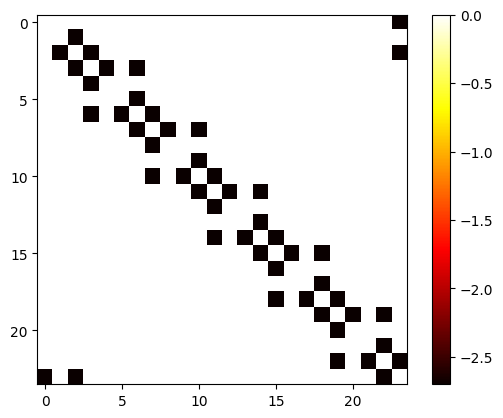

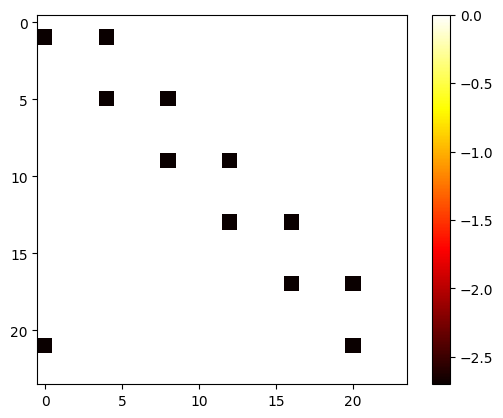

In [30]:
H0, T = build_real_space_hamiltonian(n=n, m=m, length=ncells, bond=bond, pbc=True, direction="x", beta=beta, t0=first_neighbor_hopping, cutoff=cutoff, atol=0.1)
plt.imshow(H0, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(T, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

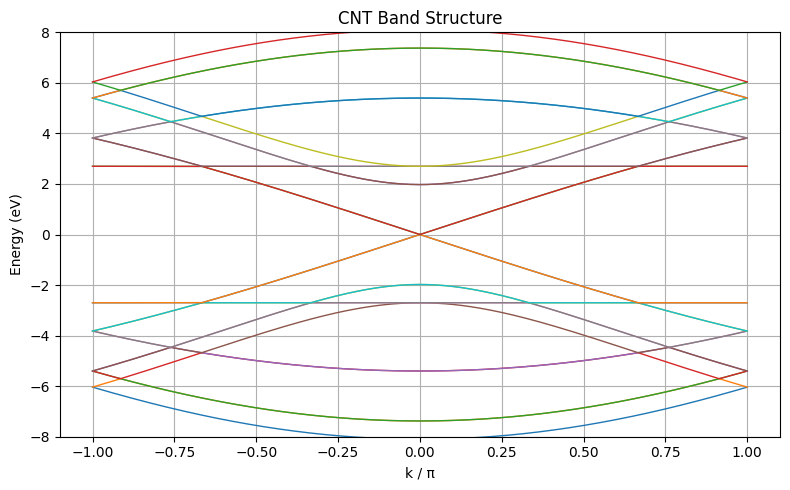

In [31]:
plot_band_structure(H0,T)